GRUPO:

*   ARTUR
*   FAVALESSA
*   MANETTI
*   SCHOWANTZ





#Trilateração

Redes de Trilateração são baseadas na medição de distâncias entre estações, levantadas com equipamentos como estação total. Atualmente, são empregadas normalmente em regiões onde o levantamento GNSS seria menos viável, como regiões com altas edificações ou de vegetação alta e densa.

O ajustamento destas redes pode ser realizado pelo modelo paramétrico (UD VI de Ajust Basico) - caso não linear (solução iterativa).

Ajuste a rede de trilateração abaixo, calculando o vetor dos parâmetros estimados $x$ e a matriz covariância dos parâmetros $\Sigma_x$:

Dados:

P1: coordenadas $x_1=100$, $y_1=100$ (injunção fixa)

P5: coordenadas $x_1=300$, $y_1=150$ (injunção fixa)

Desvio padrão de todas as observações é de $10mm$.

De | Para | Distância medida (m)
---|---|--
1 |2| 104.4226
1 |3| 141.4264
1 |4| 100.0186
1 |6| 70.6993
2 |3| 130.0119
2 |4| 164.0010
2 |5| 128.0688
2 |6| 169.9940
3 |4| 100.0009
3 |5| 111.7834
3 |6| 158.1090
4 |5| 206.1490
4 |6| 70.6874
5 |6| 250.0094


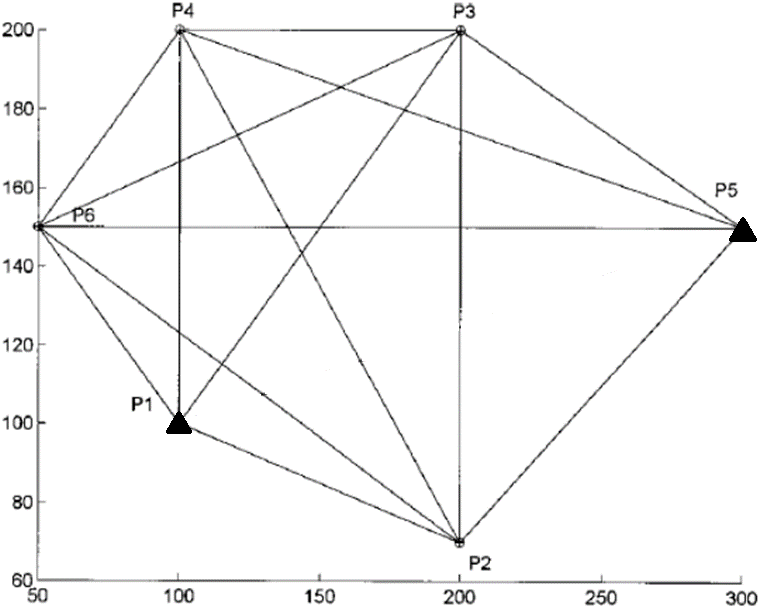

Obs: da análise do croqui da rede, pode-se obter o seguinte chute inicial para as coordenadas:
$x_2=200$, $y_2=65$,
$x_3=200$, $y_3=200$,
$x_4=100$, $y_4=200$,
$x_6=50$, $y_6=150$

## Solução

In [6]:
import numpy as np

# 1. Pontos conhecidos (fixos)
P1 = np.array([100.0, 100.0])
P5 = np.array([300.0, 150.0])

# 2. Aproximações iniciais (m)
# Vetor de parâmetros [X2,Y2, X3,Y3, X4,Y4, X6,Y6]
X = np.array([
    200.0,  80.0,   # P2
    200.0, 200.0,   # P3
    100.0, 200.0,   # P4
     50.0, 150.0    # P6
], dtype=float)

# 3. Observações: De, Para, Distância (m)
obs = [
    (1, 2, 104.4226),
    (1, 3, 141.4264),
    (1, 4, 100.0186),
    (1, 6,  70.6993),
    (2, 3, 130.0119),
    (2, 4, 164.0010),
    (2, 5, 128.0688),
    (2, 6, 169.9940),
    (3, 4, 100.0009),
    (3, 5, 111.7834),
    (3, 6, 158.1090),
    (4, 5, 206.1490),
    (4, 6,  70.6874),
    (5, 6, 250.0094)
]

# 4. Configuração do ajustamento
sigma = 0.010    # 10 mm
P = (1/sigma**2) * np.eye(len(obs))
tol = 1e-6
max_iter = 15

# Mapeamento dos pontos desconhecidos
ids_desconhecidos = [2, 3, 4, 6]
idx = {pid: 2*i for i, pid in enumerate(ids_desconhecidos)}

def coord(pid, X):
    """Retorna coordenadas do ponto pid"""
    if pid == 1: return P1
    if pid == 5: return P5
    i = idx[pid]
    return np.array([X[i], X[i+1]])

# 5. Iterações do método de Gauss-Newton
print("RELATÓRIO – AJUSTAMENTO DE TRILATERAÇÃO (Modelo Paramétrico)")

for it in range(1, max_iter+1):
    n = len(obs)
    u = len(X)
    A = np.zeros((n, u))
    L0 = np.zeros((n, 1))
    L = np.zeros((n, 1))

    # Montagem de A, L0 e L
    for i, (p1, p2, dij) in enumerate(obs):
        C1 = coord(p1, X)
        C2 = coord(p2, X)
        dx = C1[0] - C2[0]
        dy = C1[1] - C2[1]
        dcalc = np.sqrt(dx**2 + dy**2)
        L0[i] = dcalc
        L[i] = dij

        # Derivadas
        if p1 in idx:
            j = idx[p1]
            A[i, j]   =  dx / dcalc
            A[i, j+1] =  dy / dcalc
        if p2 in idx:
            k = idx[p2]
            A[i, k]   = -dx / dcalc
            A[i, k+1] = -dy / dcalc

    # Vetor das inovações
    W = L - L0

    # Sistema normal
    N = A.T @ P @ A
    U = A.T @ P @ W
    dX = np.linalg.solve(N, U)

    # Atualiza coordenadas
    X += dX.flatten()

    # Impressão de iteração
    print(f"\nIteração {it}:")
    print(f"  Correção máxima = {np.max(np.abs(dX)):.6e} m")
    print(f"  Coordenadas parciais:")
    for pid in ids_desconhecidos:
        j = idx[pid]
        print(f"    P{pid}: X = {X[j]:.4f} m | Y = {X[j+1]:.4f} m")

    # Verifica convergência
    if np.max(np.abs(dX)) < tol:
        print("\nCritério de convergência atingido (10⁻⁶).")
        break

# 6. Resultado final
print("RESULTADOS FINAIS – COORDENADAS AJUSTADAS")
for pid in ids_desconhecidos:
    j = idx[pid]
    print(f"P{pid}: X = {X[j]:.4f} m | Y = {X[j+1]:.4f} m")

# 7. Cálculo dos resíduos e variância unitária
A = np.zeros((len(obs), len(X)))
L0 = np.zeros((len(obs), 1))
L = np.zeros((len(obs), 1))
for i, (p1, p2, dij) in enumerate(obs):
    C1 = coord(p1, X)
    C2 = coord(p2, X)
    dx = C1[0] - C2[0]
    dy = C1[1] - C2[1]
    dcalc = np.sqrt(dx**2 + dy**2)
    L0[i] = dcalc
    L[i] = dij
    if p1 in idx:
        j = idx[p1]
        A[i, j]   =  dx / dcalc
        A[i, j+1] =  dy / dcalc
    if p2 in idx:
        k = idx[p2]
        A[i, k]   = -dx / dcalc
        A[i, k+1] = -dy / dcalc

W = L - L0
N = A.T @ P @ A
dx = np.linalg.solve(N, A.T @ P @ W)
v = A @ dx - W
sigma0 = np.sqrt((v.T @ P @ v) / (len(obs) - len(X)))

print("AVALIAÇÃO DO AJUSTAMENTO")
print(f"Variância unitária posterior σ₀² = {sigma0.item()**2:.3e}")
print(f"Desvio padrão unitário σ₀ = {sigma0.item():.3e} m")
print("\nResíduos (m):")
for i, (p1, p2, _) in enumerate(obs):
    print(f"  {p1}-{p2}: {v[i].item():+.4f}")


RELATÓRIO – AJUSTAMENTO DE TRILATERAÇÃO (Modelo Paramétrico)

Iteração 1:
  Correção máxima = 1.026954e+01 m
  Coordenadas parciais:
    P2: X = 200.1512 m | Y = 69.7305 m
    P3: X = 200.0405 m | Y = 199.8444 m
    P4: X = 100.0476 m | Y = 199.9370 m
    P6: X = 50.0041 m | Y = 149.9943 m

Iteração 2:
  Correção máxima = 2.619775e-01 m
  Coordenadas parciais:
    P2: X = 200.0019 m | Y = 69.9924 m
    P3: X = 200.0130 m | Y = 199.9985 m
    P4: X = 100.0087 m | Y = 199.9998 m
    P6: X = 50.0126 m | Y = 150.0107 m

Iteração 3:
  Correção máxima = 2.195041e-04 m
  Coordenadas parciais:
    P2: X = 200.0020 m | Y = 69.9927 m
    P3: X = 200.0130 m | Y = 199.9985 m
    P4: X = 100.0087 m | Y = 199.9999 m
    P6: X = 50.0126 m | Y = 150.0107 m

Iteração 4:
  Correção máxima = 1.803713e-08 m
  Coordenadas parciais:
    P2: X = 200.0020 m | Y = 69.9927 m
    P3: X = 200.0130 m | Y = 199.9985 m
    P4: X = 100.0087 m | Y = 199.9999 m
    P6: X = 50.0126 m | Y = 150.0107 m

Critério de conver